# Example 7 from: [Markov conditions and factorization in logical credal networks](https://doi.org/10.1016/j.ijar.2024.109237)

In [51]:
# Imports

from dowhy import CausalModel
import sys
sys.path.append('../')
from parser_uai import UAIParser

## First Variation

![First_Variation](./figures/image.png)

### Modeling and Data

In [2]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data


,X1,X2,U1,U2,U3
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,1,1,1,1,0
996,1,1,1,1,0
997,1,1,1,1,0
998,1,1,1,1,0


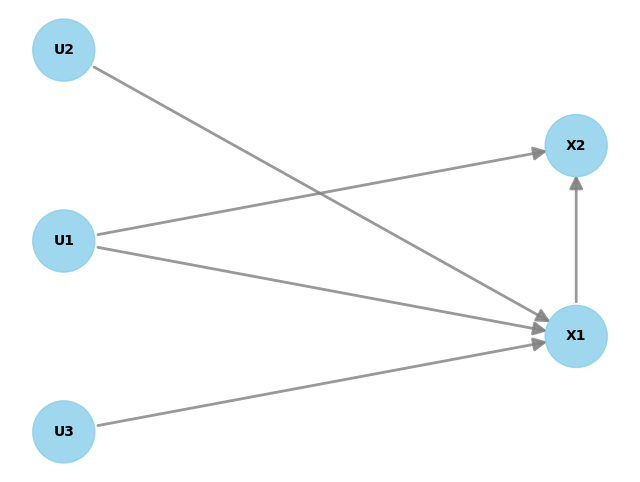

In [3]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [4]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations

- `PropensityScoreStratification` does not work, because there is not enough data to generate at least two strata. 
- The assumptions for the `iv` estimand are not suitable in this case.
- Both methods yielded results very close to the expected value.

In [5]:
# Expected value

mean_X2_X1_1 = data[data['X1'] == 1].groupby('U1')['X2'].mean()
mean_X2_X1_0 = data[data['X1'] == 0].groupby('U1')['X2'].mean()

ate = (mean_X2_X1_1.mean() - mean_X2_X1_0.mean())

print(f"Average Treatment Effect (ATE): {ate}")

Average Treatment Effect (ATE): 0.5


In [6]:
# Propensity score matching

estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print("ATE: ", estimate_matching.value)

ATE:  0.5


In [7]:
# Propensity score weighting

estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print("ATE: ", estimate_weighting.value)

ATE:  0.5152805073833049


### Refutation

- The placebo treatment suggests that randomizing the treatment creates a noticeable (and statistically significant) shift in the estimated effect for weighting.
- However, the weighting approach does not introduce significant bias based on the dummy outcome test.

In [8]:
# Placebo treatment refuter

refuter_matching_placebo = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="placebo_treatment_refuter"
)

refuter_weighting_placebo = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="placebo_treatment_refuter"
)

In [9]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_placebo, refuter_weighting_placebo))

Matching:
Refute: Use a Placebo Treatment
Estimated effect:0.5
New effect:0.0
p value:1.0

Weighting:
Refute: Use a Placebo Treatment
Estimated effect:0.5152805073833049
New effect:-0.3842307624256941
p value:0.0



In [10]:
# Dummy outcome refuter

refuter_matching_dummy = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

refuter_weighting_dummy = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="dummy_outcome_refuter"
)

In [11]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_dummy[0], refuter_weighting_dummy[0]))

Matching:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.12076763228182173
p value:0.82

Weighting:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.015194720256262983
p value:0.8400000000000001



In [12]:
refuter_matching_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_matching, 
    method_name="random_common_cause"
)

refuter_weighting_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_weighting, 
    method_name="random_common_cause"
)

In [13]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_rcc, refuter_weighting_rcc))

Matching:
Refute: Add a random common cause
Estimated effect:0.5
New effect:0.5
p value:1.0

Weighting:
Refute: Add a random common cause
Estimated effect:0.5152805073833049
New effect:0.5152805073833048
p value:1.0



### What if?

**Inputing data only for X1 and X2**

- DoWhy only identifies `iv` estimand.
- When using an `iv` estimator like `iv.instrumental_variable`, it raises an error for missing data

In [42]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn1.uai", ["X1", "X2", "U1", "U2", "U3"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data = data.drop(columns=['U1', 'U2', 'U3'])
# data

In [43]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

# model.view_model()

c:\Python310\lib\site-packages\dowhy\causal_model.py:582: UserWarning: 3 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


In [44]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                               -1⎤
 ⎢    d         ⎛    d          ⎞  ⎥
E⎢─────────(X₂)⋅⎜─────────([X₁])⎟  ⎥
 ⎣d[U₃  U₂]     ⎝d[U₃  U₂]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→X2 then ¬(U →→{U3,U2})
Estimand assumption 2, Exclusion: If we remove {U3,U2}→{X1}, then ¬({U3,U2}→X2)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [45]:
try:
    estimate = model.estimate_effect(
        identified_estimand, 
        method_name="iv.instrumental_variable"
    )
    
    print(estimate)

except Exception as e:
    print(e)

"None of [Index(['U3', 'U2'], dtype='object')] are in the [columns]"


## Second Variation

![Second_Variation](./figures/image-1.png)

### Modeling and Data

In [46]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn2.uai", ["X1", "X2", "U1", "U2"])
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data

,X1,X2,U1,U2
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
95,1,1,1,1
96,1,1,1,1
97,1,1,1,1
98,1,1,1,1


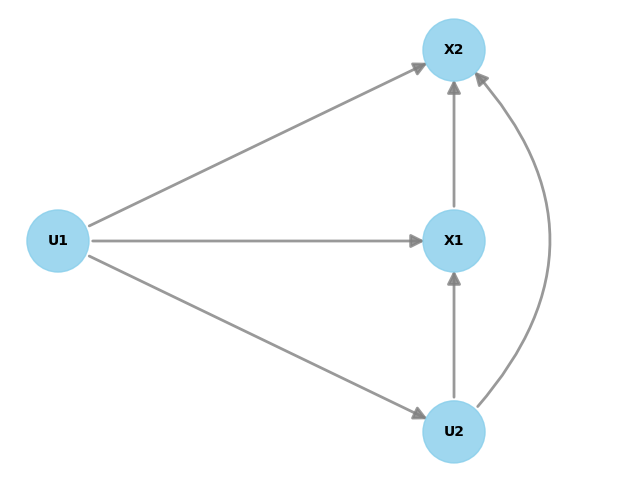

In [47]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.graph
)

model.view_model()

### Identifying

In [50]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U1,U2])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U2,U) = P(X2|X1,U1,U2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations

- `PropensityScoreStratification` does not work, because there is not enough data to generate at least two strata.
- 

In [23]:
# Expected value

mean_X2_X1_1 = data[data['X1'] == 1].groupby(["U1", "U2"]).sum()
mean_X2_X1_0 = data[data['X1'] == 0].groupby('U1')

print(mean_X2_X1_1.mean())

ate = (mean_X2_X1_1.mean() - mean_X2_X1_0.mean())

# print(f"Average Treatment Effect (ATE): {ate}")

X1    25.000000
X2    16.666667
dtype: float64


In [59]:
# Propensity score matching

estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print("ATE: ", estimate_matching.value)

ATE:  0.5


In [58]:
# Propensity score weighting

estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print("ATE: ", estimate_weighting.value)

ATE:  0.658359063044163


### Refutation

- The placebo treatment suggests that randomizing the treatment creates a noticeable (and statistically significant) shift in the estimated effect for weighting.
- However, the weighting approach does not introduce significant bias based on the dummy outcome test.

In [ ]:
# Placebo treatment refuter

refuter_matching_placebo = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="placebo_treatment_refuter"
)

refuter_weighting_placebo = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="placebo_treatment_refuter"
)

In [ ]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_placebo, refuter_weighting_placebo))

Matching:
Refute: Use a Placebo Treatment
Estimated effect:0.5
New effect:0.0
p value:1.0

Weighting:
Refute: Use a Placebo Treatment
Estimated effect:0.5152805073833049
New effect:-0.3846422367543312
p value:0.0



In [ ]:
# Dummy outcome refuter

refuter_matching_dummy = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

refuter_weighting_dummy = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="dummy_outcome_refuter"
)

In [ ]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_dummy[0], refuter_weighting_dummy[0]))

Matching:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.027940892865407577
p value:0.9

Weighting:
Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.010138566073804643
p value:0.98



In [ ]:
refuter_matching_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_matching, 
    method_name="random_common_cause"
)

refuter_weighting_rcc =model.refute_estimate(
    identified_estimand, 
    estimate_weighting, 
    method_name="random_common_cause"
)

In [ ]:
print("Matching:\n{}\nWeighting:\n{}".format(refuter_matching_rcc, refuter_weighting_rcc))

Matching:
Refute: Add a random common cause
Estimated effect:0.5
New effect:0.5
p value:1.0

Weighting:
Refute: Add a random common cause
Estimated effect:0.5152805073833049
New effect:0.5152805073833048
p value:1.0



#### Propensity score stratification

In [17]:
estimate_stratification = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_stratification")

print(estimate_stratification)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: -0.020480059093859276



In [18]:
# Placebo Treatment Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_stratification,
    method_name="placebo_treatment_refuter"
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.020480059093859276
New effect:0.0011948064132950764
p value:0.8999999999999999



#### Propensity score matching

In [19]:
estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print(estimate_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: 0.002



In [20]:
# Dummy Outcome Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.020613760052734287
p value:0.98



#### Propensity score weighting

In [21]:
# Propensity Score Weighting
estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print(estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[X2|U2,U1])
d[X₁]             
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U2,U1,U) = P(X2|X1,U2,U1)

## Realized estimand
b: X2~X1+U2+U1
Target units: ate

## Estimate
Mean value: -0.020095280113678116



In [22]:
# Random Common Cause Refuter - Weighting

ref = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="random_common_cause"
)

print(ref)

Refute: Add a random common cause
Estimated effect:-0.020095280113678116
New effect:-0.020095280113678112
p value:1.0



## Third Variation

![Third_Variantion](figures/image-3.png)

### Modeling and Data

In [23]:
# Parsing the UAI file
model_uai = UAIParser("../uai_examples/example-lcn3.uai")
model_uai.parse()

# Load the data
data = model_uai.generate_data()
data.columns = ["X1", "X2", "U1"]
data.head()

,X1,X2,U1
0,0,1,1
1,1,0,0
2,0,0,0
3,0,1,2
4,0,1,0


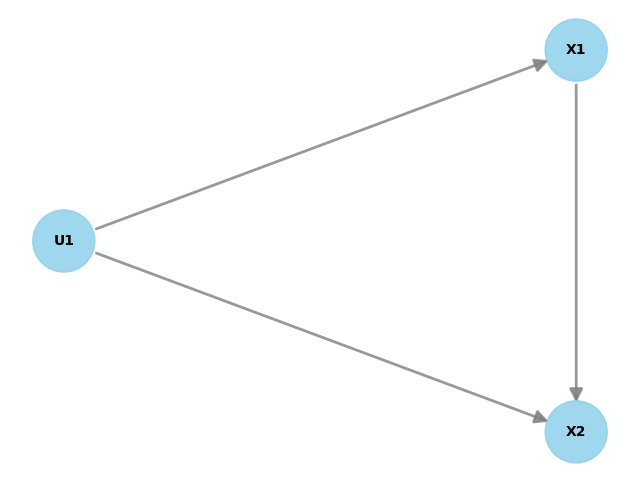

In [24]:
# Modeling
model = CausalModel(
    data=data,
    treatment="X1",
    outcome="X2",
    graph=model_uai.set_nodes(["X1", "X2", "U1", "U2", "U3"])
)

model.view_model()

### Identifying

In [25]:
# Identifying the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimations / Refutations

#### Propensity score stratification

In [26]:
estimate_stratification = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_stratification")

print(estimate_stratification)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.010204907656406024



In [27]:
# Placebo Treatment Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_stratification,
    method_name="placebo_treatment_refuter"
)

print(ref)

Refute: Use a Placebo Treatment
Estimated effect:-0.010204907656406024
New effect:0.0024053727131342333
p value:0.8400000000000001



#### Propensity score matching

In [28]:
estimate_matching = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching")

print(estimate_matching)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.04000000000000001



In [29]:
# Dummy Outcome Refuter

ref = model.refute_estimate(
    identified_estimand,
    estimate_matching,
    method_name="dummy_outcome_refuter"
)

print(ref[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.01393470112195305
p value:0.96



#### Propensity score weighting

In [30]:
# Propensity Score Weighting
estimate_weighting = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_weighting")

print(estimate_weighting)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[X2|U1])
d[X₁]          
Estimand assumption 1, Unconfoundedness: If U→{X1} and U→X2 then P(X2|X1,U1,U) = P(X2|X1,U1)

## Realized estimand
b: X2~X1+U1
Target units: ate

## Estimate
Mean value: -0.010656034541316917



In [31]:
# Random Common Cause Refuter - Weighting

ref = model.refute_estimate(
    identified_estimand,
    estimate_weighting,
    method_name="random_common_cause"
)

print(ref)

Refute: Add a random common cause
Estimated effect:-0.010656034541316917
New effect:-0.010656034541316917
p value:1.0



## Some Conclusions

In all variations, the `PropensityScoreMatching` method generated different $ATE$ values, when compared with both of the other `PropensityScore...` ones. 

Besides, in the [First Variation](#first-variation), we utilized the `InstrumentalVariableEstimator` method. However, we observed that the estimated value was significantly beyond the acceptable range (between -1 and 1), especially considering that the outcome is a binary variable.
